In [1]:
using LinearAlgebra
using SparseArrays
using Random
using CairoMakie
using Statistics
using DynamicalSystemsBase
using ProgressMeter
using DataFrames
using StatsBase

In [2]:
include("EchoStateNetworks.jl")
using .EchoStateNetworks
include("ONReservoir.jl")
using .ONReservoir
include("TurningError.jl")
using .TurningError

In [3]:
# total_time = 300
# time_delta = 0.01
# ts_str = ["x", "y", "z"]
# init_conds = [-15.0,-15.0,10.0]
# lo_variables = [10, 8/3, 28]
# init_time_to_ignore = 10

total_time = 500
time_delta = 0.05
ts_str = ["x", "y", "z"]
init_conds = [-15.0,-15.0,10.0]
lo_variables = [10, 8/3, 28]
init_time_to_ignore = 10

10

In [4]:
function Lorenz(u, p, t)
    σ = p[1]
    β = p[2]
    ρ = p[3]

    du1 = σ*(u[2]-u[1])
    du2 = u[1]*(ρ-u[3]) - u[2]
    du3 = u[1]*u[2] - β*u[3]

    return SVector(du1, du2, du3)
end

Lorenz (generic function with 1 method)

In [5]:
lo = CoupledODEs(Lorenz, init_conds, lo_variables)
lo_tr, tvec = trajectory(lo, total_time; Δt = time_delta, Ttr = init_time_to_ignore)

(3-dimensional StateSpaceSet{Float64} with 10001 points, 10.0:0.05:510.0)

In [6]:
function SplitSet(set, ratio)
    split_point = trunc(Int, ratio*length(set))
    train_set = set[1:split_point]
    test_set = set[split_point+1:length(set)]
    
    return(train_set, test_set)
end

SplitSet (generic function with 1 method)

In [7]:
lo_train, lo_test = SplitSet(lo_tr[:,1], 0.8)

([5.126534053596909, 5.834707413699581, 6.991808357426451, 8.530218492050775, 10.224320148458034, 11.579262391541565, 11.948150768409606, 11.02325560795919, 9.2017949533067, 7.247977130696019  …  5.077681027821892, 3.0478176252011457, 1.9279701157144167, 1.437857386040465, 1.353230578626462, 1.5580404279676863, 2.033744024173971, 2.844270111435518, 4.130680100078396, 6.098330280510625], [8.922748372508533, 12.38960052200712, 15.193402641819919, 15.120150964731685, 11.69730215411192, 7.1630730712588315, 3.5237195165663295, 1.2226732082648095, -0.08865301351516021, -0.862771191380489  …  -8.078234078985824, -9.74934151620846, -11.246056374765327, -11.93797064120169, -11.372904735504541, -9.750263627364301, -7.78378266119449, -6.121317642617538, -5.0527320746766256, -4.600820630976283])

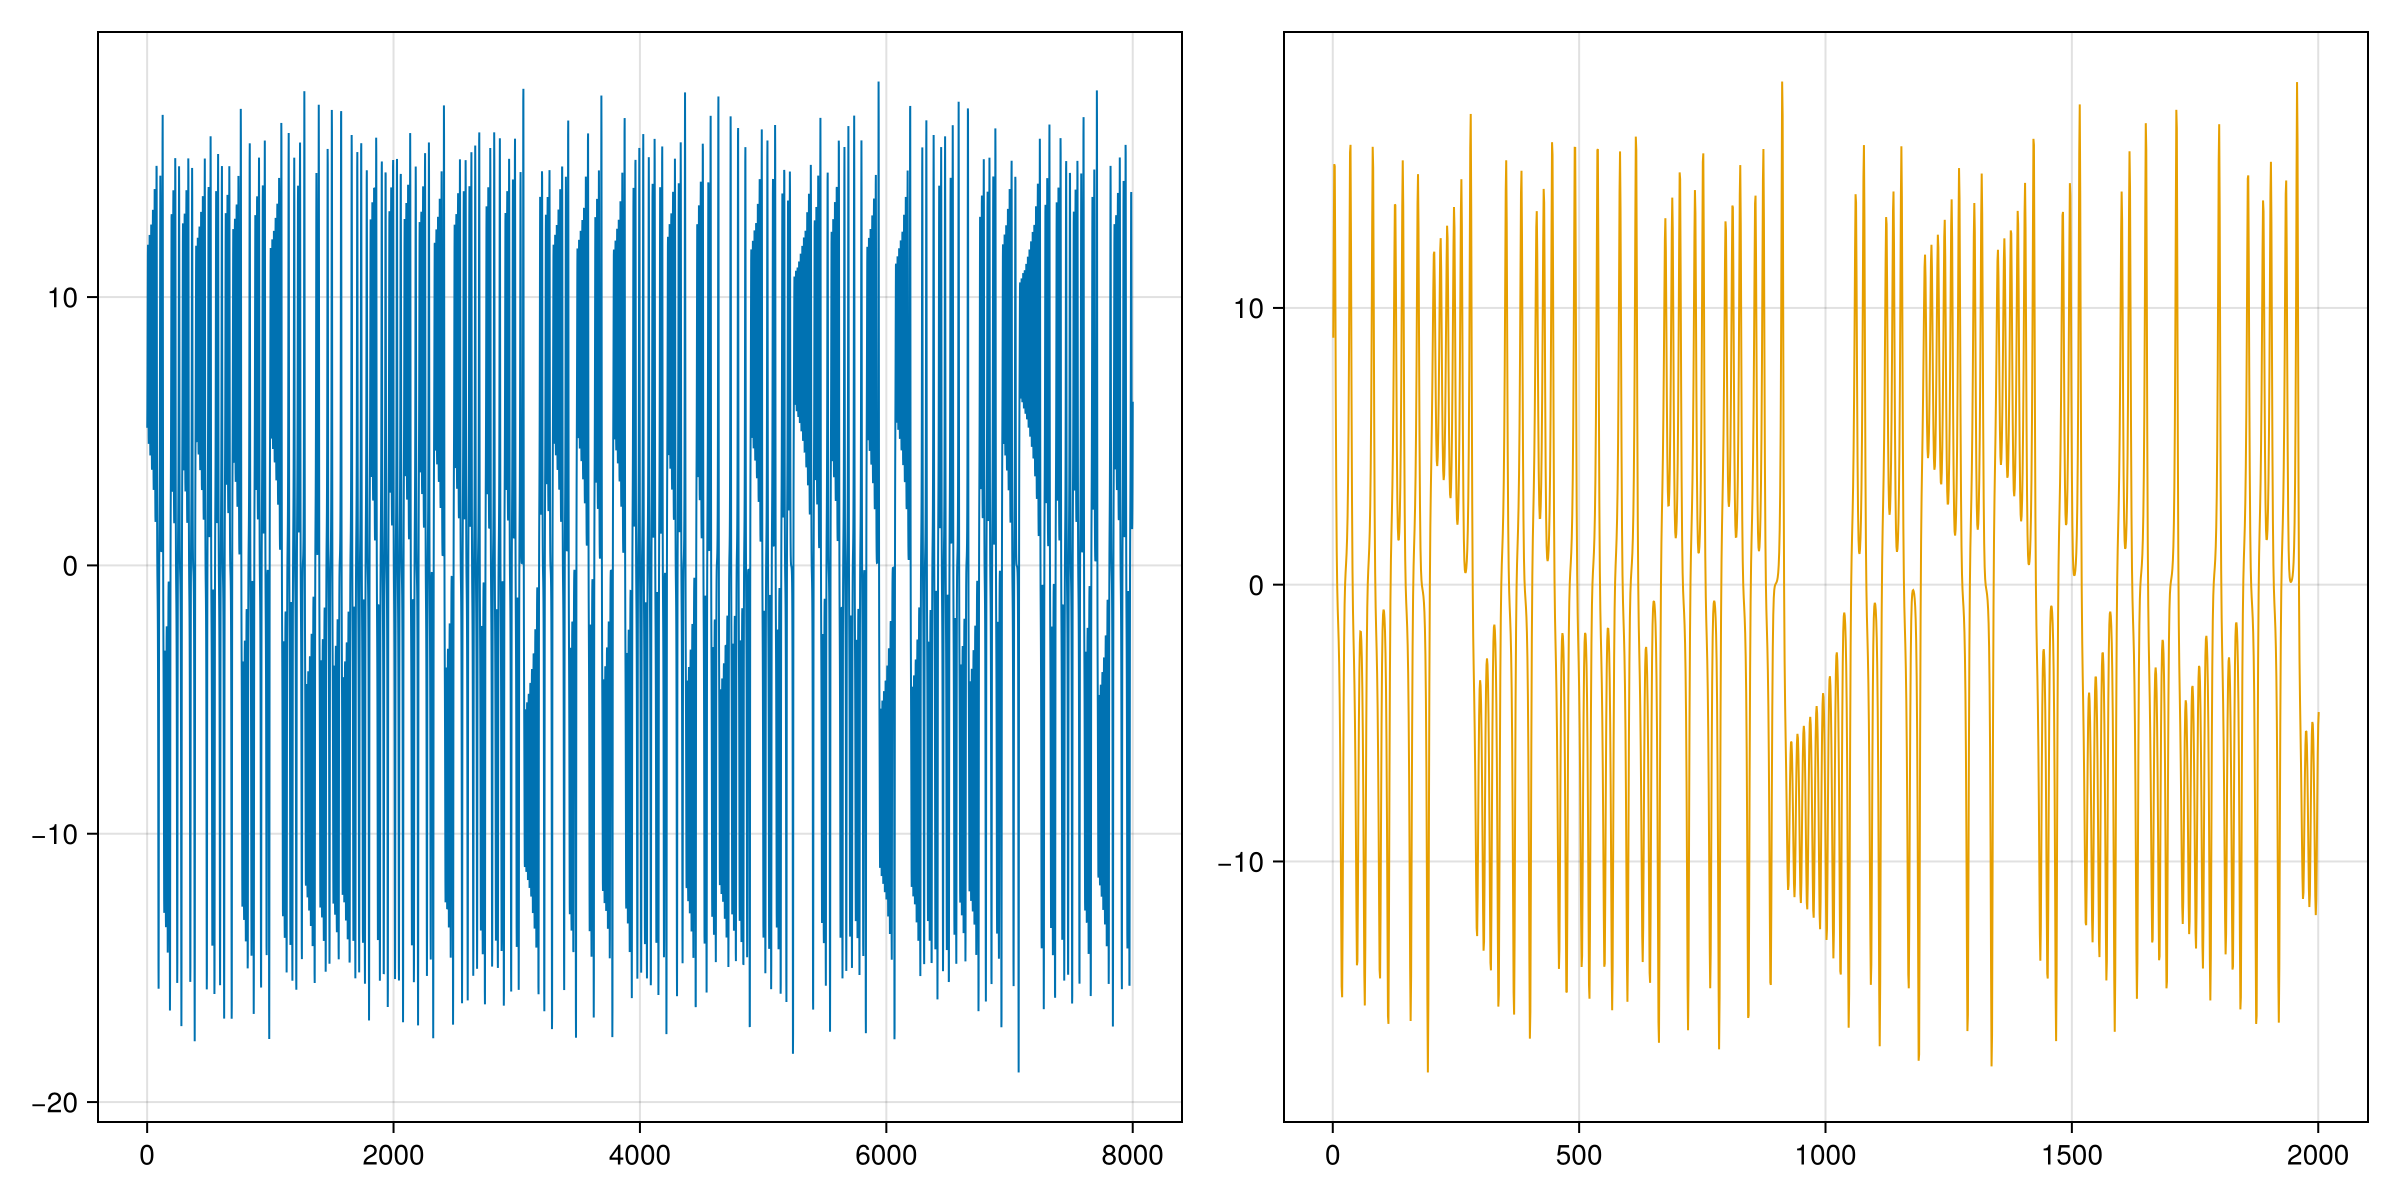

In [8]:
fig = Figure( size = (1200,600) )
lines!(Axis(fig[1,1]), lo_train; linewidth = 1.0, color = Cycled(1))
lines!(Axis(fig[1,2]), lo_test; linewidth = 1.0, color = Cycled(2))
fig

In [9]:
test_ON_part_adjacency = Dict(
    1 => [2],
    2 => [3],
    3 => [1]
)

k = 8
d = 3
ρ = 2.0
α = 1.0
η = 1/maximum(lo_train)
β = 0.001

ESN_params = create_ESN_params(k, d, ρ, α, η, β, num_partitions=3, part_connection=1, ON_part_adjacency=test_ON_part_adjacency)

DataFrame(ESN_params.V_rec, :auto)

24×24 DataFrame
 Row │ x1        x2        x3        x4       x5        x6        x7        x8 ⋯
     │ Float64   Float64   Float64   Float64  Float64   Float64   Float64   Fl ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.0       0.0       0.0       0.0      0.661881  0.0       0.0       0. ⋯
   2 │ 0.0       0.0       0.0       0.0      0.0       0.262206  0.0       0.
   3 │ 0.0       0.0       0.0       0.0      0.0       0.0       0.717024  0.
   4 │ 0.0       0.0       0.0       0.0      0.0       0.0       0.0       0.
   5 │ 0.661881  0.0       0.0       0.0      0.0       0.0       0.164372  0. ⋯
   6 │ 0.0       0.262206  0.0       0.0      0.0       0.0       0.0       0.
   7 │ 0.0       0.0       0.717024  0.0      0.164372  0.0       0.0       0.
   8 │ 0.0       0.136147  0.0       0.0      0.0       0.689235  0.0       0.
  ⋮  │    ⋮         ⋮         ⋮         ⋮        ⋮         ⋮         ⋮         ⋱
  18 │ 0.0       1.24814   0.0       0.0      0.0       0.0       0.0       0. ⋯
  19 │ 0.0       0.0       1.24814   0.0      0.0       0.0       0.0       0.
  20 │ 0.0       0.0       0.0       1.24814  0.0       0.0       0.0       0.
  21 │ 0.0       0.0       0.0       0.0      1.24814   0.0       0.0       0.
  22 │ 0.0       0.0       0.0       0.0      0.0       1.24814   0.0       0. ⋯
  23 │ 0.0       0.0       0.0       0.0      0.0       0.0       1.24814   0.
  24 │ 0.0       0.0       0.0       0.0      0.0       0.0       0.0       1.
                                                   17 columns and 9 rows omitted

In [10]:
function RMSE(y_true, y_pred)
    return sqrt(mean((y_true .- y_pred) .^ 2))
end

RMSE (generic function with 1 method)

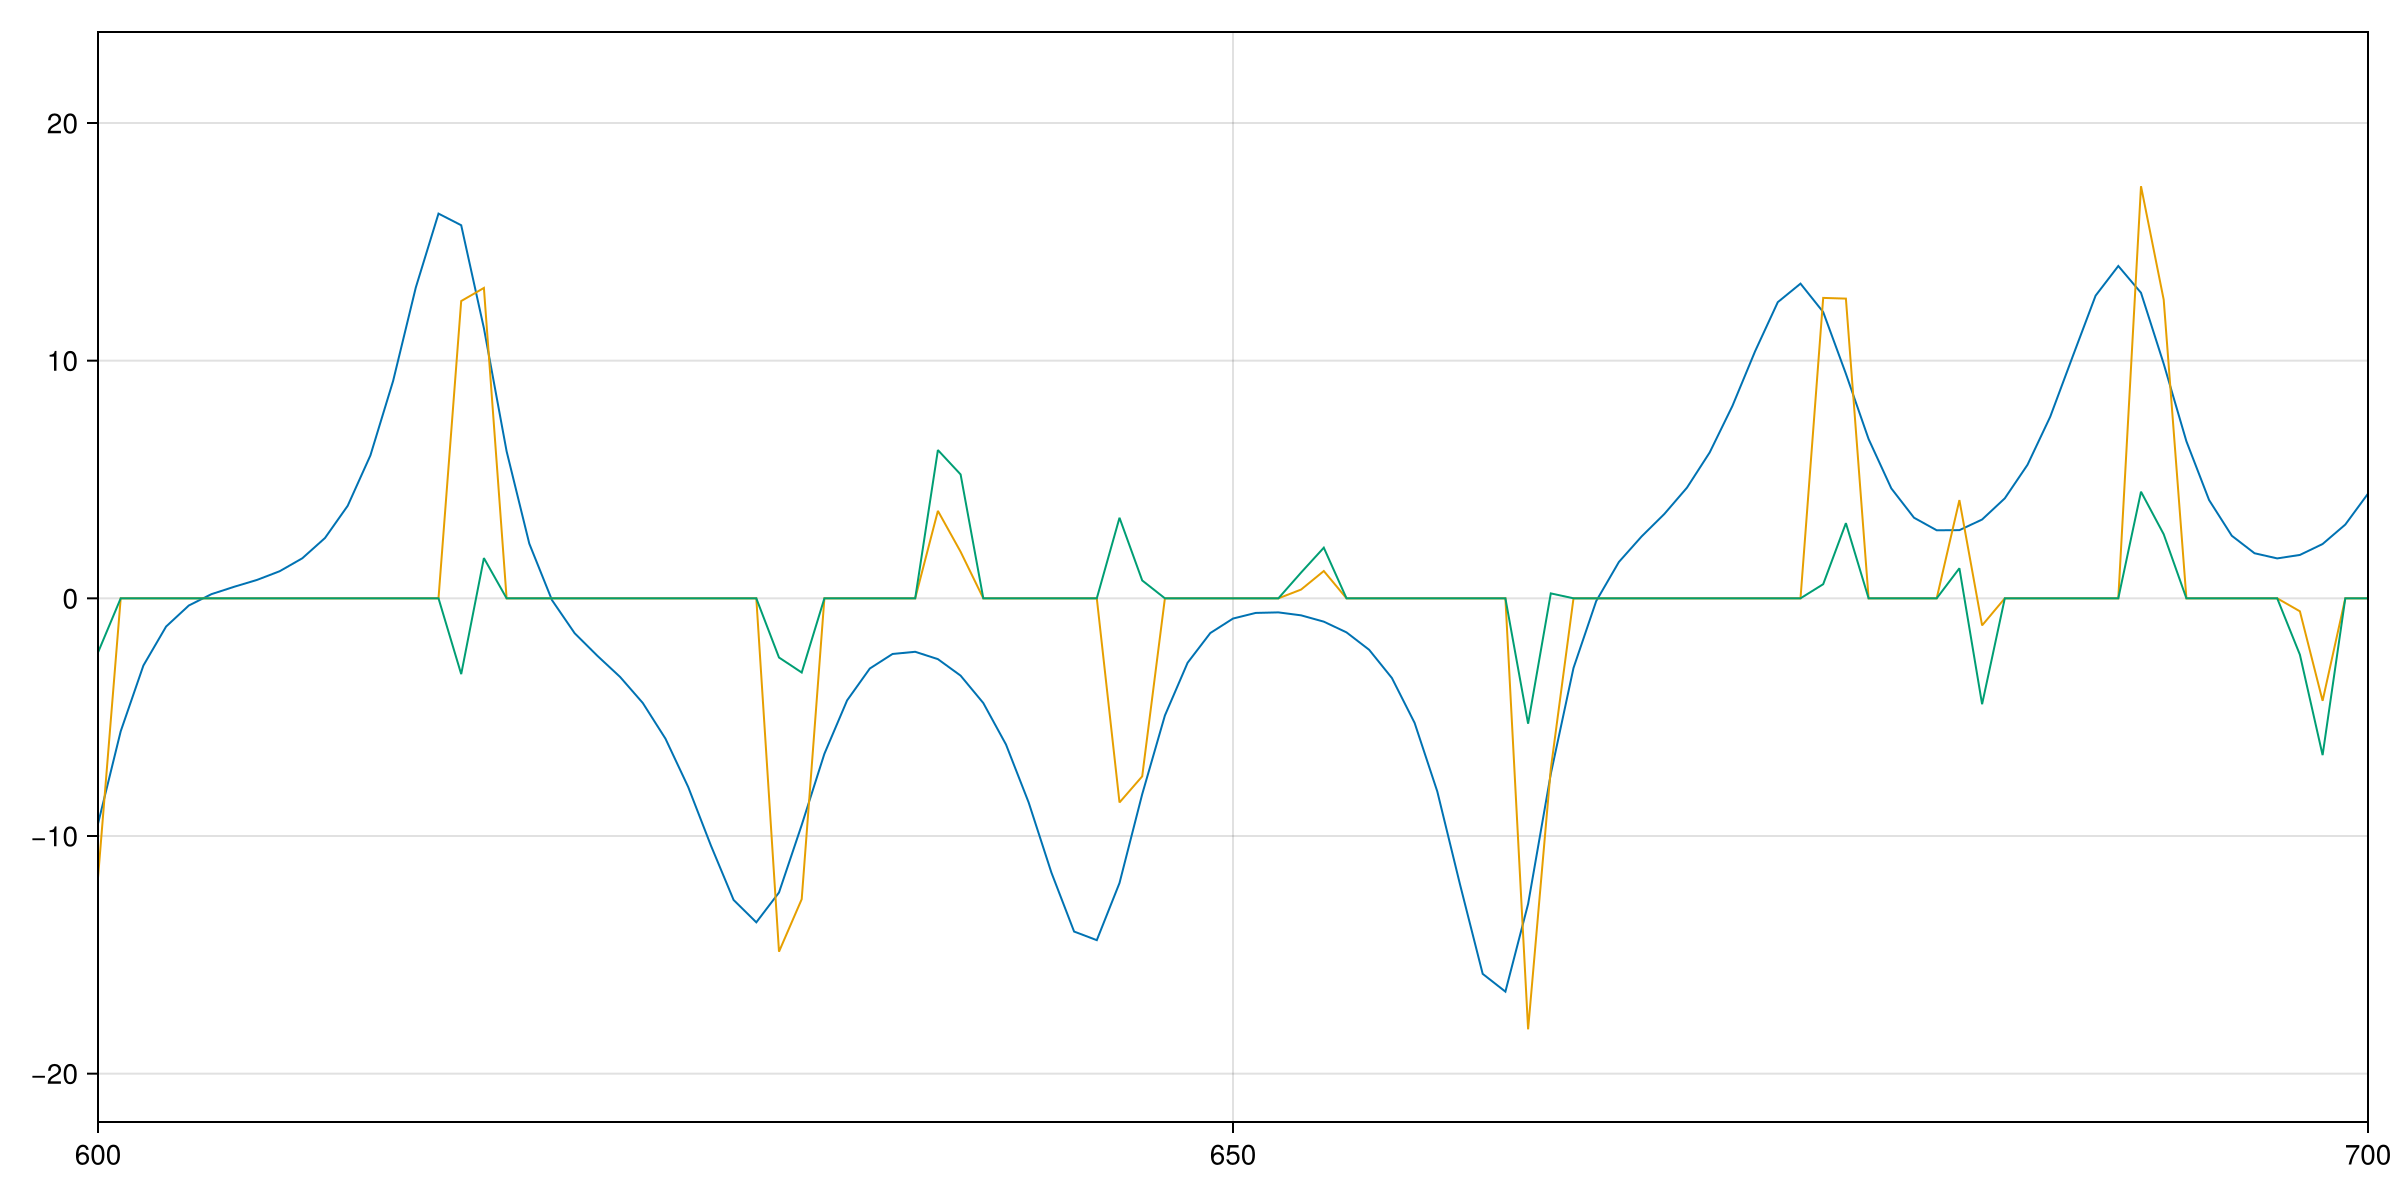

In [11]:
test_preds = lo_test + 3 * randn(length(lo_test))

test_mask = create_turning_partition_mask(lo_test, 4, 1, 1)
error = test_preds .- lo_test

fig = Figure( size = (1200,600))

ax1 = Axis(fig[1,1])
lines!(ax1, lo_test; linewidth = 1.0, color = Cycled(1))
lines!(ax1, test_preds .* test_mask; linewidth = 1.0, color = Cycled(2))
lines!(ax1, error .* test_mask; linewidth = 1.0, color = Cycled(3))

xlims!(600,700)

fig

In [12]:
function compare_preds(ON_preds, vanilla_preds, x_start, x_end; calculate_error=true, ignore_first=0, offset=1)
    ON_preds_cropped = ON_preds[ignore_first+1:end]
    vanilla_preds_cropped = vanilla_preds[ignore_first+1:min(length(ON_preds), end)]
    lo_test_cropped = lo_test[offset+ignore_first+1:min(length(ON_preds_cropped)+offset+ignore_first, end)]

    if calculate_error
        println("Ordinal network reservoir prediction RMSE: ", RMSE(ON_preds_cropped, lo_test_cropped))
        println("Vanilla prediction RMSE: ", RMSE(vanilla_preds_cropped, lo_test_cropped))
        println("Ordinal network reservoir prediction turning partition RMSE: ", turning_partition_RMSE(ON_preds_cropped, lo_test_cropped))
        println("Vanilla prediction turning partition RMSE: ", turning_partition_RMSE(vanilla_preds_cropped, lo_test_cropped))
    end

    fig = Figure( size = (1200,600))

    ax1 = Axis(fig[1,1])
    lines!(ax1, ON_preds_cropped; linewidth = 1.0, color = Cycled(1))
    lines!(ax1, lo_test_cropped; linewidth = 1.0, color = Cycled(2))

    xlims!(x_start,x_end)
    ylims!(-25,25)

    ax2 = Axis(fig[1,2])
    lines!(ax2, vanilla_preds_cropped; linewidth = 1.0, color = Cycled(1))
    lines!(ax2, lo_test_cropped; linewidth = 1.0, color = Cycled(2))

    xlims!(x_start,x_end)
    ylims!(-25,25)

    fig
end

compare_preds (generic function with 1 method)

## Single step predictions

In [13]:
function create_pred_for_params(m; k = 100, part_connection=0.5, d = k*0.05, ρ = 1.2, α = 1.0, η = 1/maximum(lo_train), β = 0.001, w = 1, τ = 2)
    window_size = (m-1)*τ
    
    part_symbols_train, unique_partitions_train = create_ordinal_partition(lo_train, m, w, τ)
    trans_adjacency_matrix = create_transition_matrix(part_symbols_train)
    num_partitions = length(unique_partitions_train)
    trans_adjacency_map = trans_adjacency_matrix_to_map(trans_adjacency_matrix, num_partitions)

    ESN_params = create_ESN_params(k, d, ρ, α, η, β, num_partitions=num_partitions, part_connection=part_connection, ON_part_adjacency=trans_adjacency_map)

    R, train_states = train_one_step_pred(lo_train, ESN_params, partition_symbols=part_symbols_train)


    part_symbols_test, unique_partitions_test = create_ordinal_partition(lo_test, m, w, τ, unique_partitions=unique_partitions_train)
    preds, test_states = one_step_pred(lo_test, ESN_params, R, S = train_states[end,:], partition_symbols=part_symbols_test)

    return(preds[1:end-length(unique_partitions_test)])
end

create_pred_for_params (generic function with 1 method)

In [14]:
ON_preds = create_pred_for_params(4; k = 100, part_connection=0.5)
vanilla_preds = create_pred_for_params(1; k = 100)
;

Ordinal network reservoir prediction RMSE: 0.41556949202691157
Vanilla prediction RMSE: 0.025480085583723396
Ordinal network reservoir prediction turning partition RMSE: 3.183302840417472
Vanilla prediction turning partition RMSE: 3.067019515844265


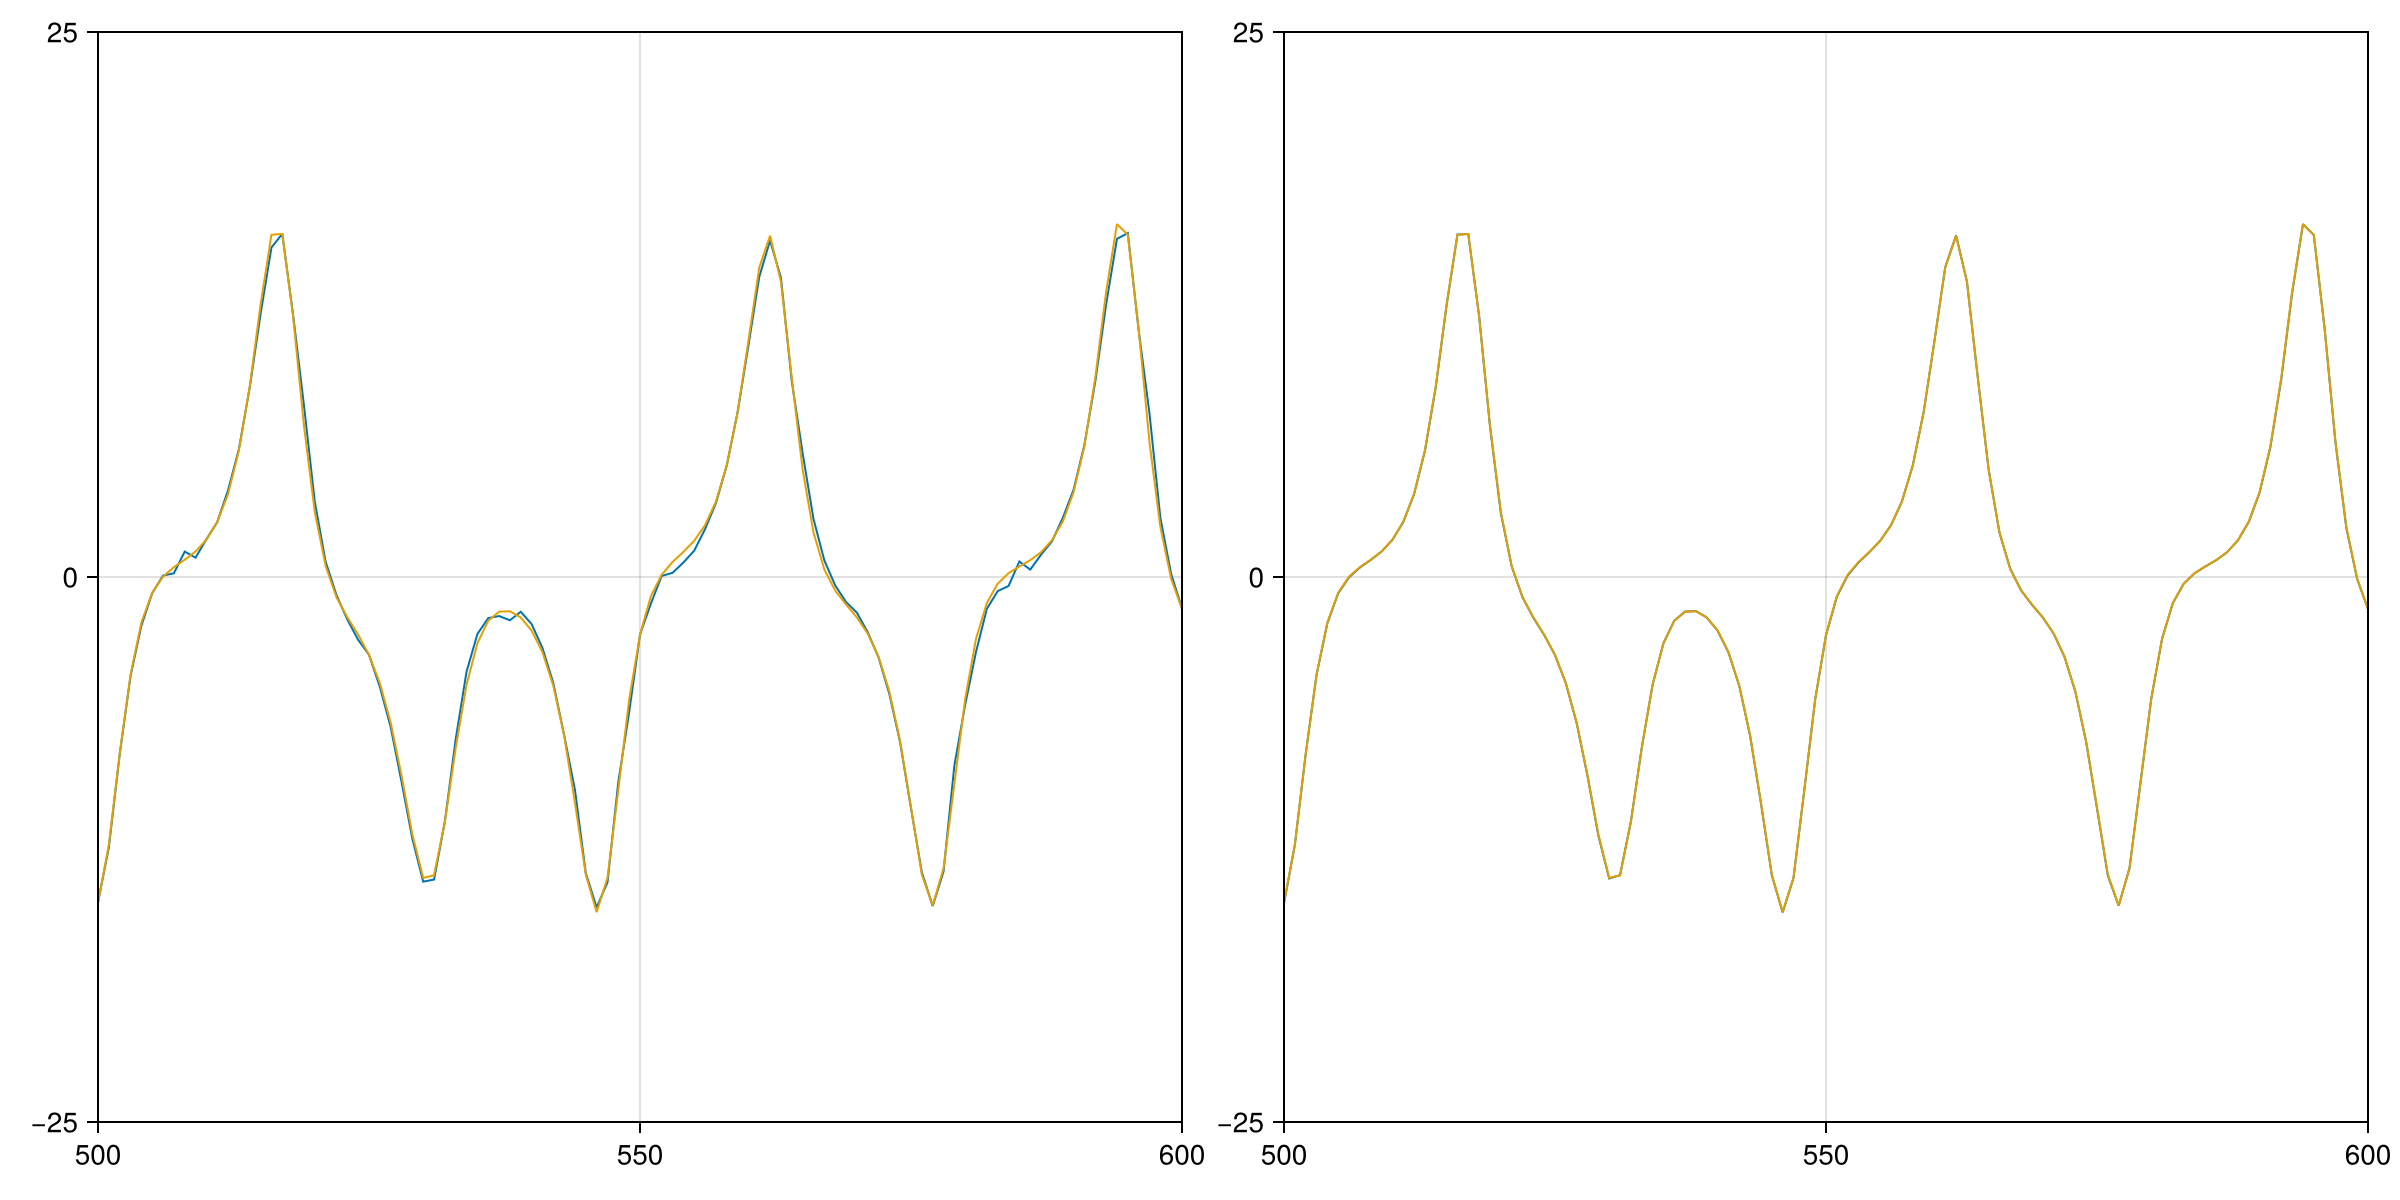

In [15]:
compare_preds(ON_preds, vanilla_preds, 500, 600, ignore_first=20)

In [16]:
ON_preds = create_pred_for_params(4; k = 10, d=2, part_connection=0.5)
vanilla_preds = create_pred_for_params(1; k = 40)
;

Ordinal network reservoir prediction RMSE: 0.8105026744422779
Vanilla prediction RMSE: 0.08736169279558714
Ordinal network reservoir prediction turning partition RMSE: 3.112289030825386
Vanilla prediction turning partition RMSE: 3.0722220677098884


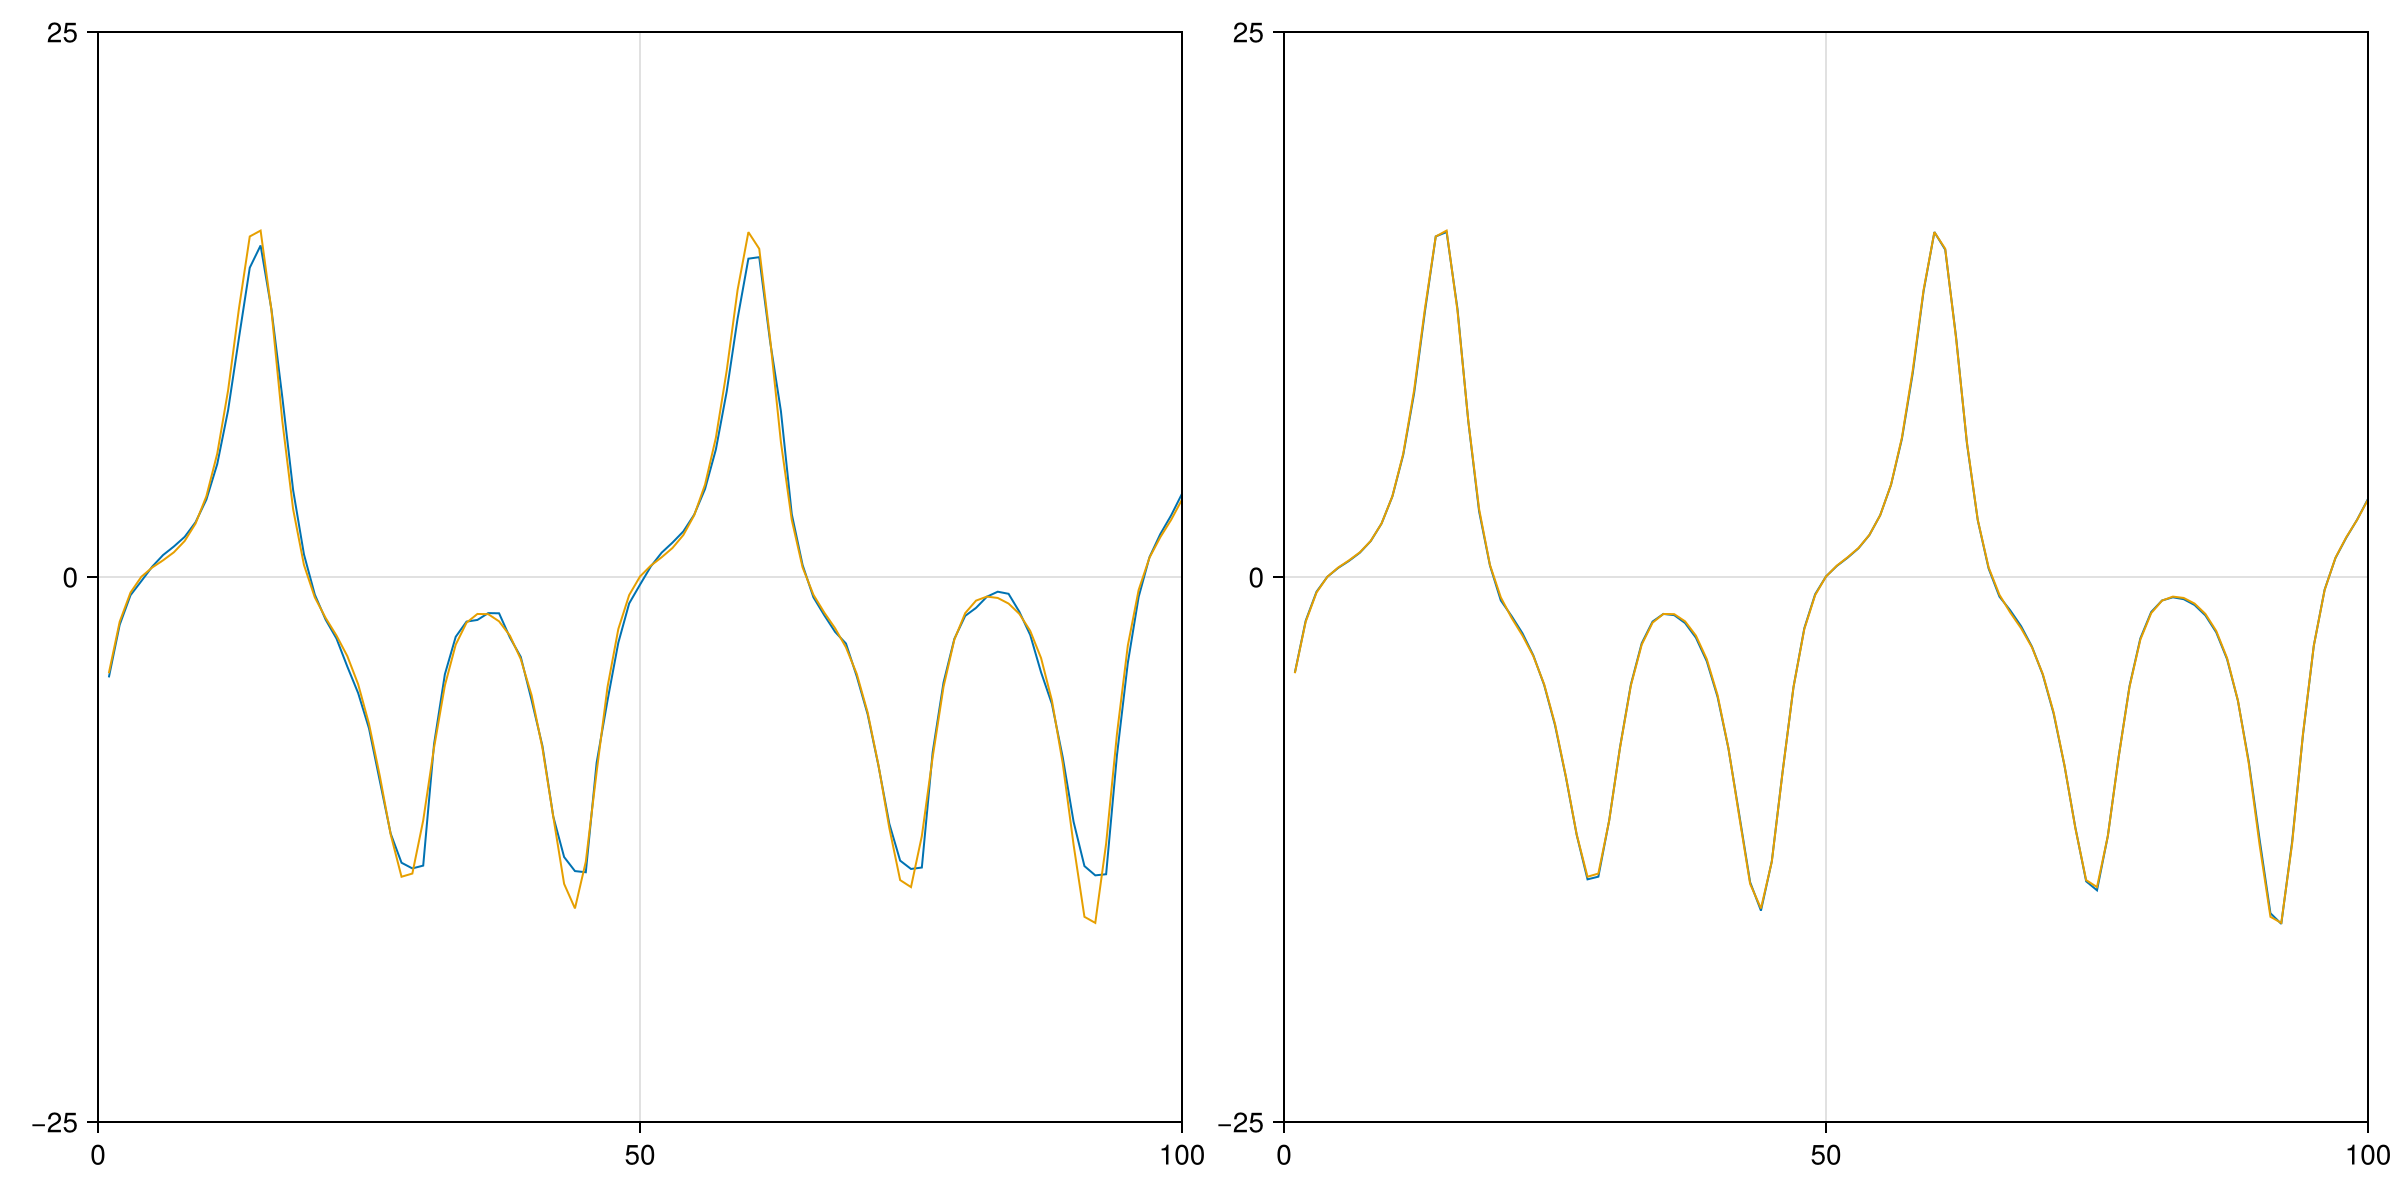

In [17]:
compare_preds(ON_preds, vanilla_preds, 0, 100, ignore_first=20)

## Freerun predictions

In [18]:
function create_pred_for_params_free_run(m; k = 100, d = k*0.05, ρ = 1.1, α = 1.0, η = 1/maximum(lo_train), β = 0.001, w = 1, τ = 1)
    window_size = (m-1)*τ
    
    part_symbols_train, unique_partitions_train = create_ordinal_partition(lo_train, m, w, τ)
    trans_adjacency_matrix = create_transition_matrix(part_symbols_train)
    num_partitions = length(unique_partitions_train)
    trans_adjacency_map = trans_adjacency_matrix_to_map(trans_adjacency_matrix, num_partitions)

    ESN_params = create_ESN_params(k, d, ρ, α, η, β, num_partitions=num_partitions, part_connection=0.05, ON_part_adjacency=trans_adjacency_map)

    R, train_states = train_one_step_pred(lo_train, ESN_params, partition_symbols=part_symbols_train)


    part_symbols_test, unique_partitions_test = create_ordinal_partition(lo_test, m, w, τ, unique_partitions=unique_partitions_train)
    
    preds = [lo_test[1]]
    state = train_states[end,:]
    for i in 2:length(part_symbols_test)
        one_freerun_pred, one_freerun_state = one_step_pred(preds[i-1], ESN_params, R, S = state, partition_symbols=part_symbols_test[i])
        one_onestep_pred, one_onestep_state = one_step_pred(lo_test[i-1], ESN_params, R, S = state, partition_symbols=part_symbols_test[i])
        pred = one_freerun_pred[1]
        state = one_onestep_state[1,:]
        # state = one_freerun_state[1,:]
        if part_symbols_test[i] == nothing
            break
            # This fills in the ends where there might not be any partition symbols
            # push!(preds, lo_test[i])
            # continue
        end
        push!(preds, pred)
    end
    
    return(preds)
end

create_pred_for_params_free_run (generic function with 1 method)

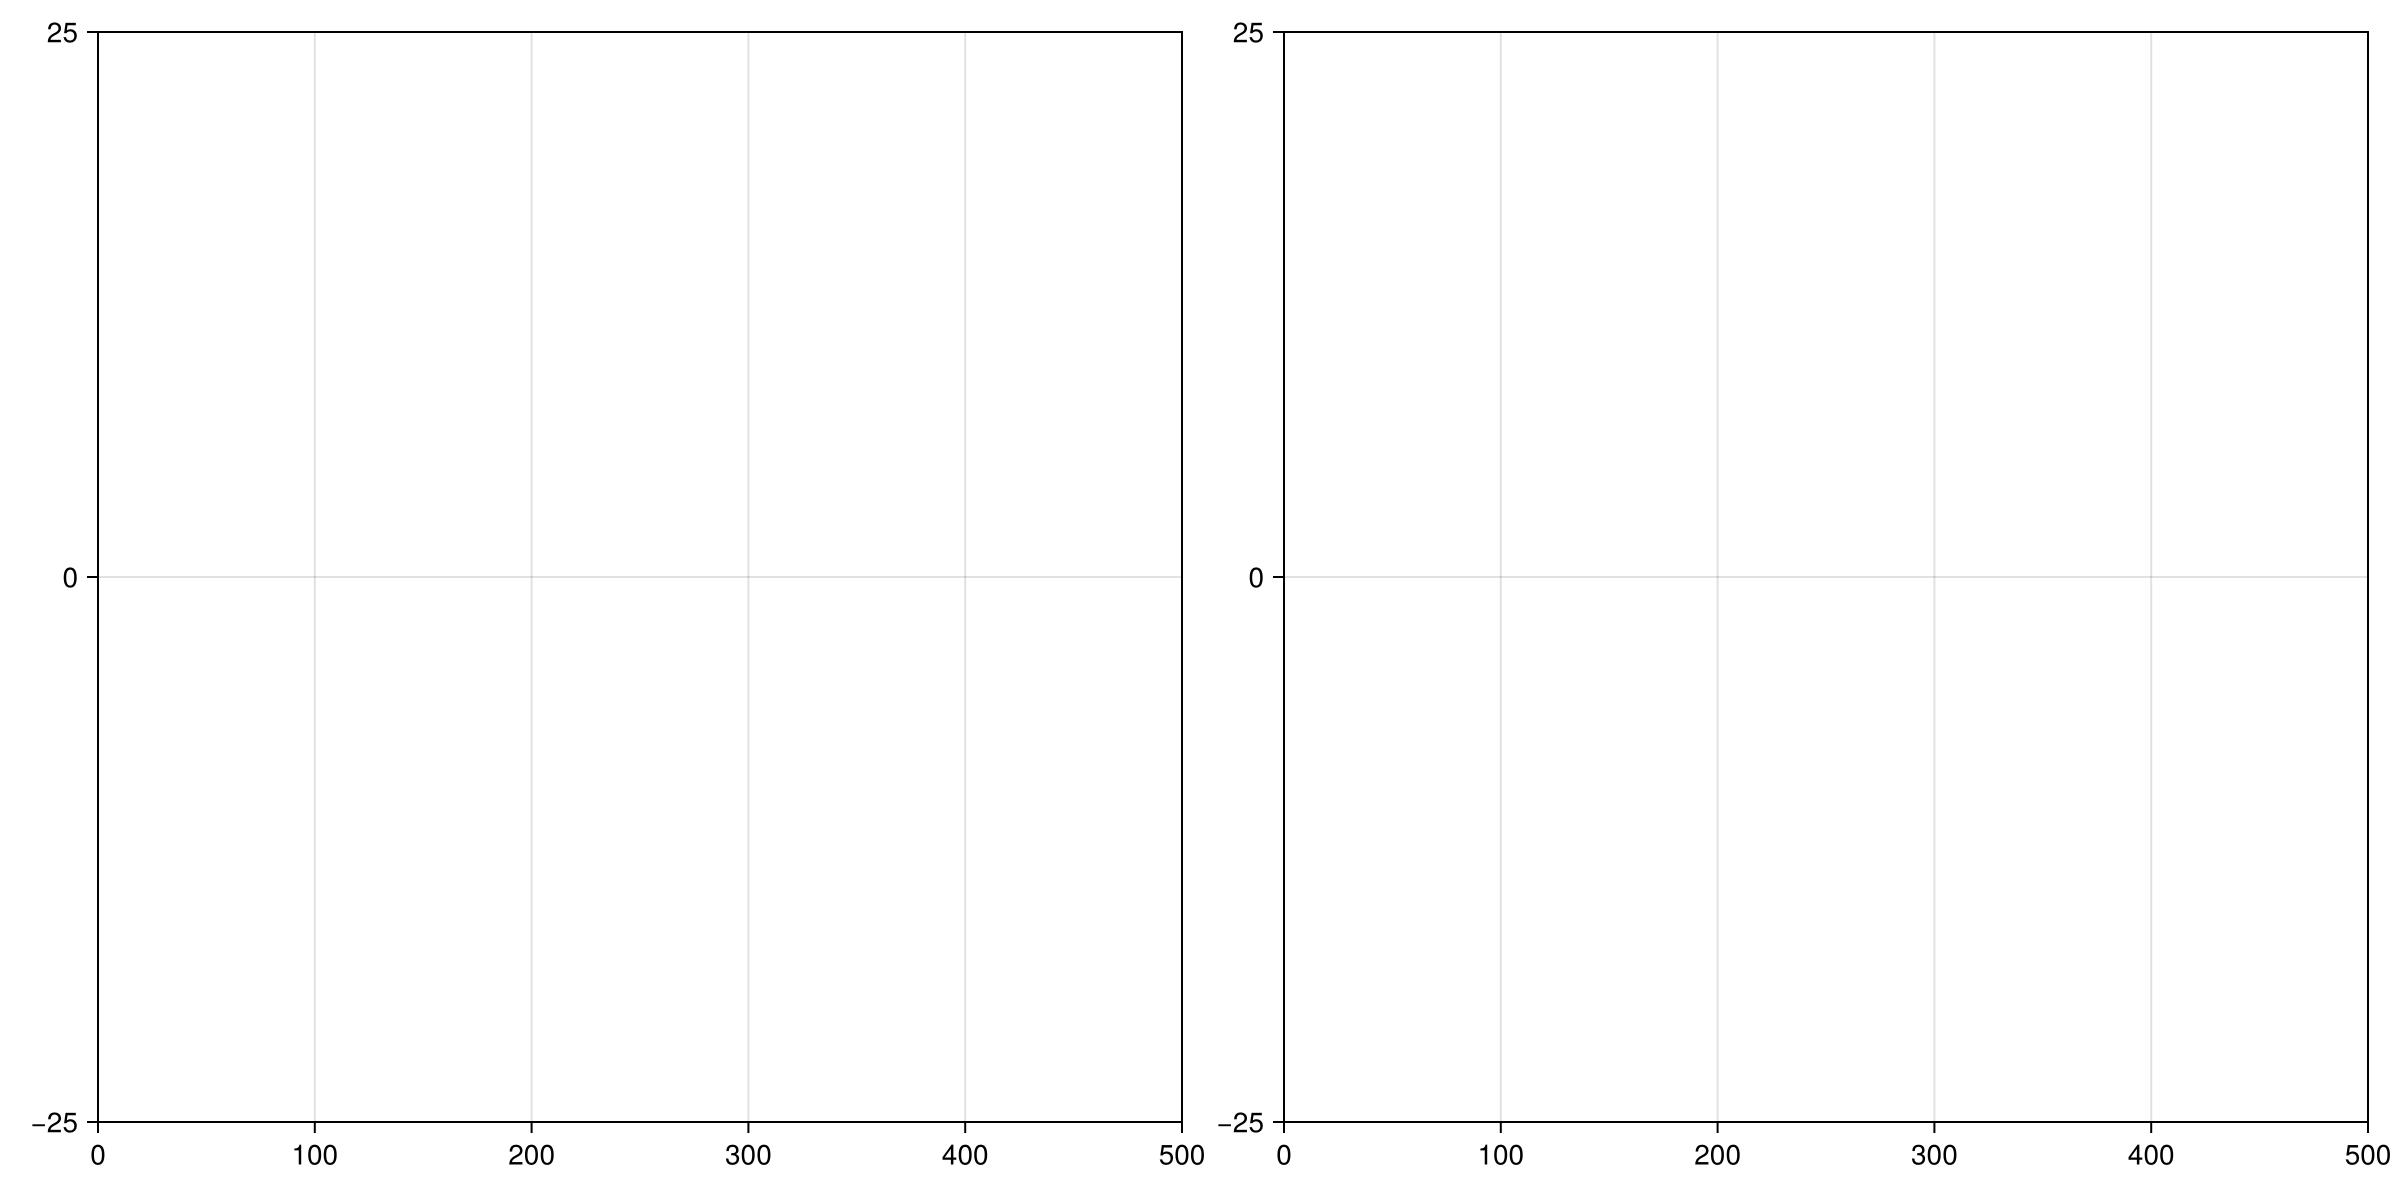

In [32]:
ON_preds_freerun = create_pred_for_params_free_run(4; k = 100)
vanilla_preds_freerun = create_pred_for_params_free_run(1; k = 400)

compare_preds(ON_preds_freerun, vanilla_preds_freerun, 0, 500, calculate_error=false)

## Multi step predictions

In [20]:
function multi_step_pred(initial_value, sub_part_symbols_test, state, R, ESN_params)
    pred, state = initial_value, state
    preds = [pred]
    
    for symbol in sub_part_symbols_test
        one_pred, one_state = one_step_pred(pred, ESN_params, R, S = state, partition_symbols=symbol)
        pred = one_pred[1]
        state = one_state[1,:]
        push!(preds, pred)
    end
    
    return(preds, state)
end

function create_pred_for_params_multi_step(m, chunk_length; k = 100, d = k*0.05, ρ = 1.1, α = 1.0, η = 1/maximum(lo_train), β = 0.001, w = 1, τ = 1)
    window_size = (m-1)*τ
    
    part_symbols_train, unique_partitions_train = create_ordinal_partition(lo_train, m, w, τ)
    trans_adjacency_matrix = create_transition_matrix(part_symbols_train)
    num_partitions = length(unique_partitions_train)
    trans_adjacency_map = trans_adjacency_matrix_to_map(trans_adjacency_matrix, num_partitions)

    ESN_params = create_ESN_params(k, d, ρ, α, η, β, num_partitions=num_partitions, part_connection=0.1, ON_part_adjacency=trans_adjacency_map)

    R, train_states = train_one_step_pred(lo_train, ESN_params, partition_symbols=part_symbols_train)

    part_symbols_test, unique_partitions_test = create_ordinal_partition(lo_test, m, w, τ, unique_partitions=unique_partitions_train)
    
    preds = []
    current_state = train_states[end,:]
    current_true_value = lo_train[end]
    i = 1
    while i+chunk_length-1 < length(part_symbols_test)
        new_preds, _ = multi_step_pred(current_true_value, part_symbols_test[i:i+chunk_length-2], current_state, R, ESN_params)
        preds = vcat(preds, new_preds)

        states = run_ESN(lo_test[i:i+chunk_length-1], ESN_params; S = current_state, partition_symbols=part_symbols_test[i:i+chunk_length-1])
        current_state = states[1,:]
        
        current_true_value = lo_test[i+chunk_length-1]
        
        i = i + chunk_length
    end
    
    return(preds[2:end])
end

create_pred_for_params_multi_step (generic function with 1 method)

In [22]:
# ESN_params.V_rec

In [23]:
# mask_V_in_for_partition([1,1,1,1,1,1,1,1,1], 2, 3, 3)

In [24]:
# function test_mask_func(V_in, partition, k, num_partitions)
#     masked_V_in = zeros(k*num_partitions, num_partitions)
    
#     for part_i in 1:num_partitions
#         masked_V_in[(part_i-1)*k+1:part_i*k, part_i] .= 1
#     end
    
#     masked_V_in = masked_V_in*one_hot_encode(partition, num_partitions).*V_in
    
#     return(masked_V_in)
# end

# stts[50,:]
# # test_mask(stts[50,:], 1, )

In [25]:
ON_preds_multistep = create_pred_for_params_multi_step(3, 2; k = 400)
vanilla_preds_multistep = create_pred_for_params_multi_step(1, 2; k = 1200);

Ordinal network reservoir prediction RMSE: 1.6426654609401354
Vanilla prediction RMSE: 0.9291371833606827
Ordinal network reservoir prediction turning partition RMSE: 4.68094319371205
Vanilla prediction turning partition RMSE: 3.112945394665287


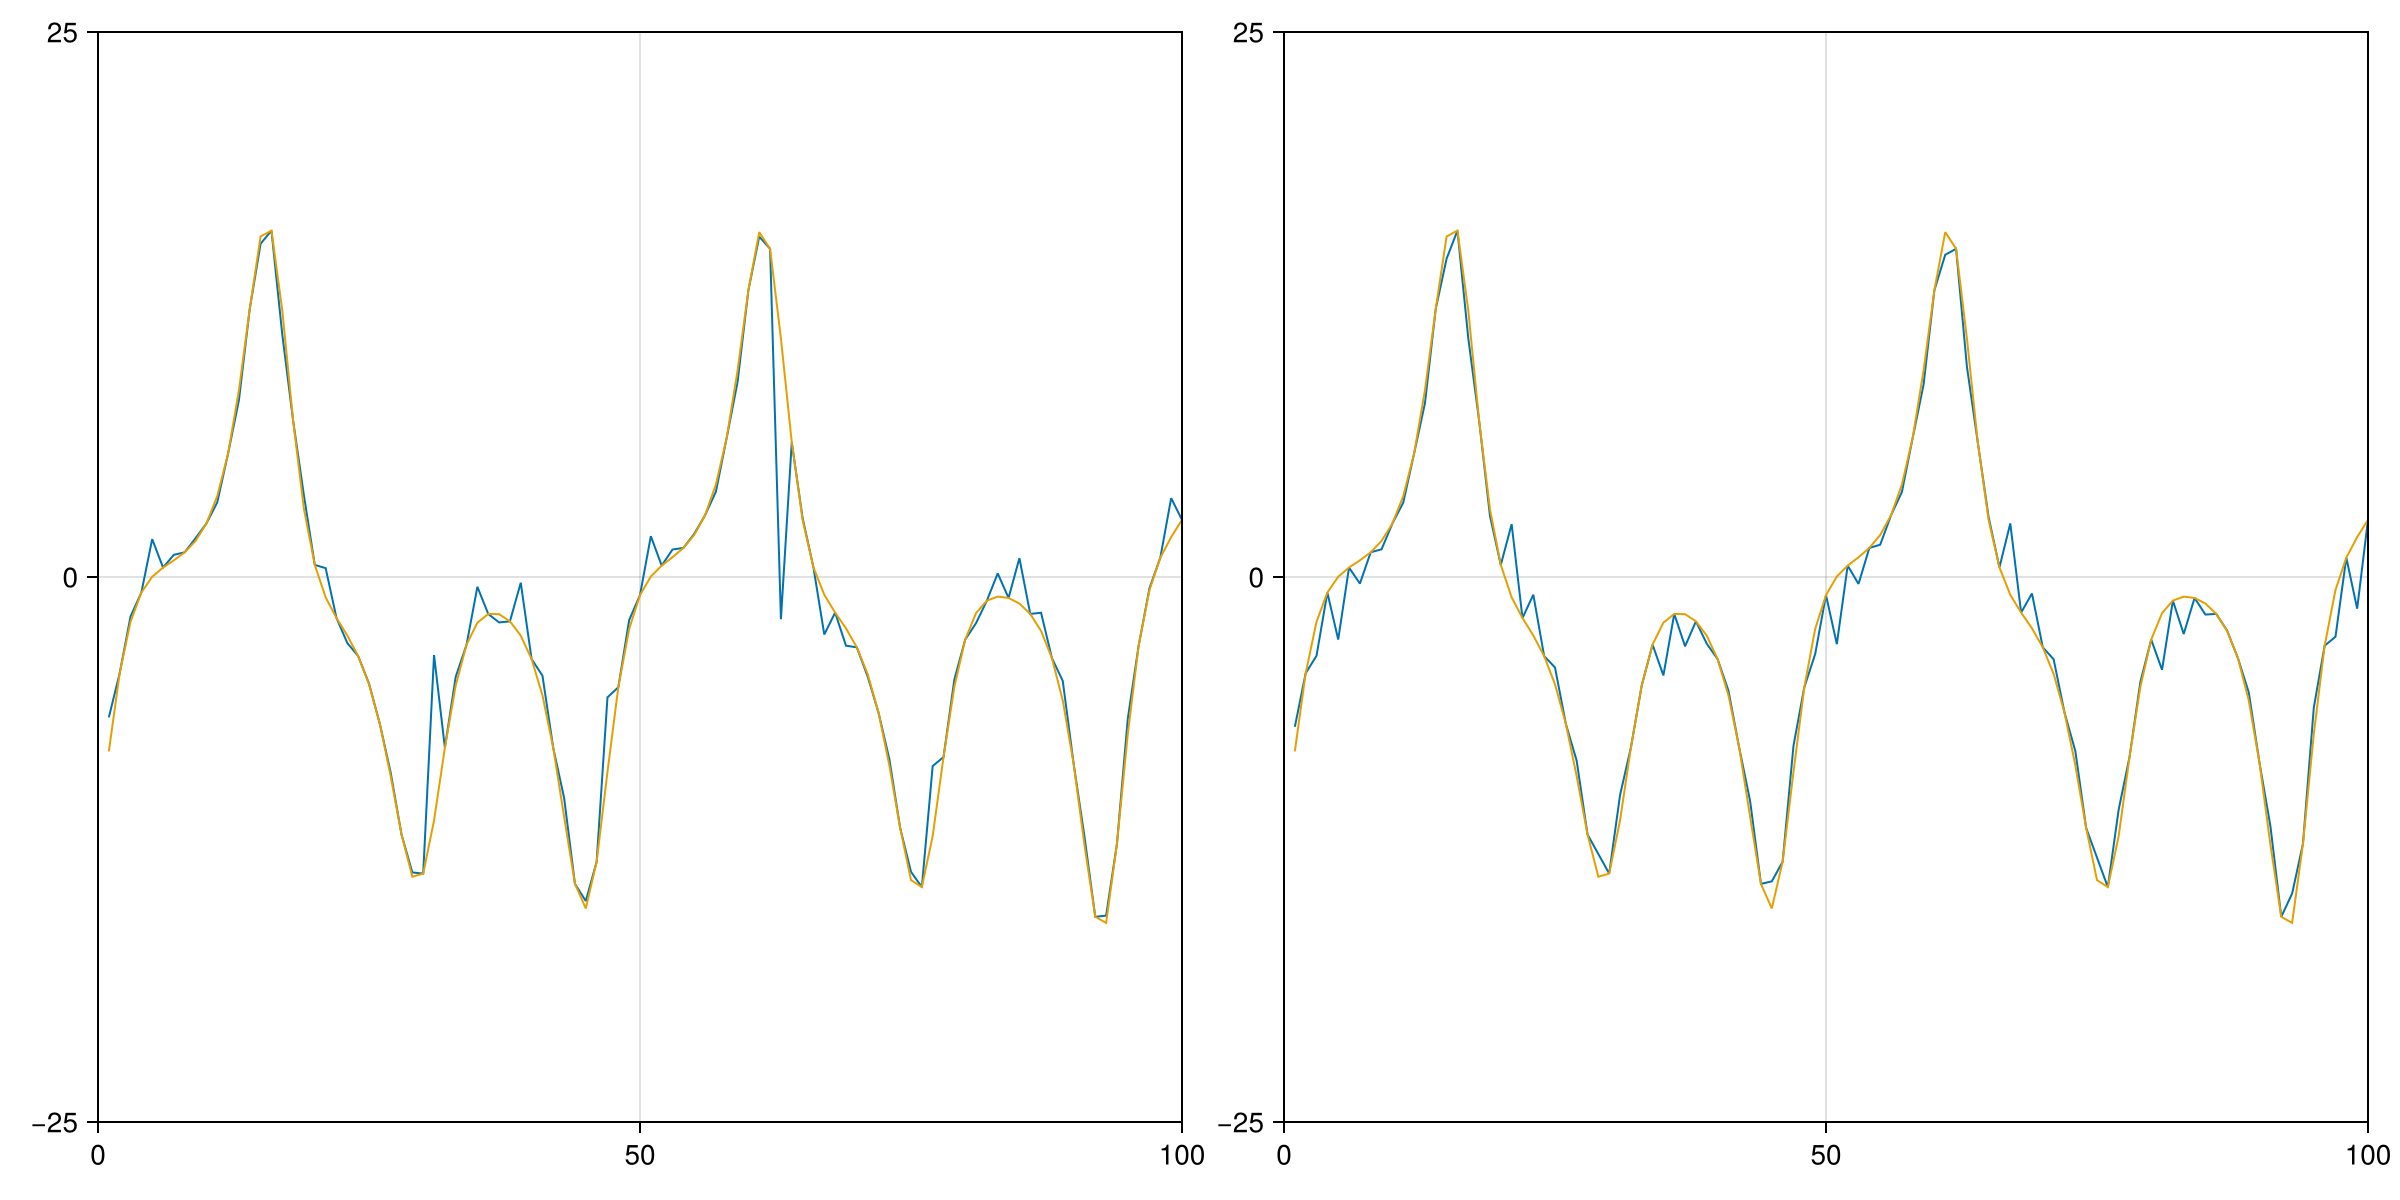

In [26]:
compare_preds(ON_preds_multistep, vanilla_preds_multistep, 0, 100, ignore_first=20, offset=0)

In [27]:
ON_preds_multistep = create_pred_for_params_multi_step(3, 3; k = 400)
vanilla_preds_multistep = create_pred_for_params_multi_step(1, 3; k = 1200);

Ordinal network reservoir prediction RMSE: 6.937057480243788
Vanilla prediction RMSE: 5.710465702125283
Ordinal network reservoir prediction turning partition RMSE: 14.776209501804008
Vanilla prediction turning partition RMSE: 5.754687399326348


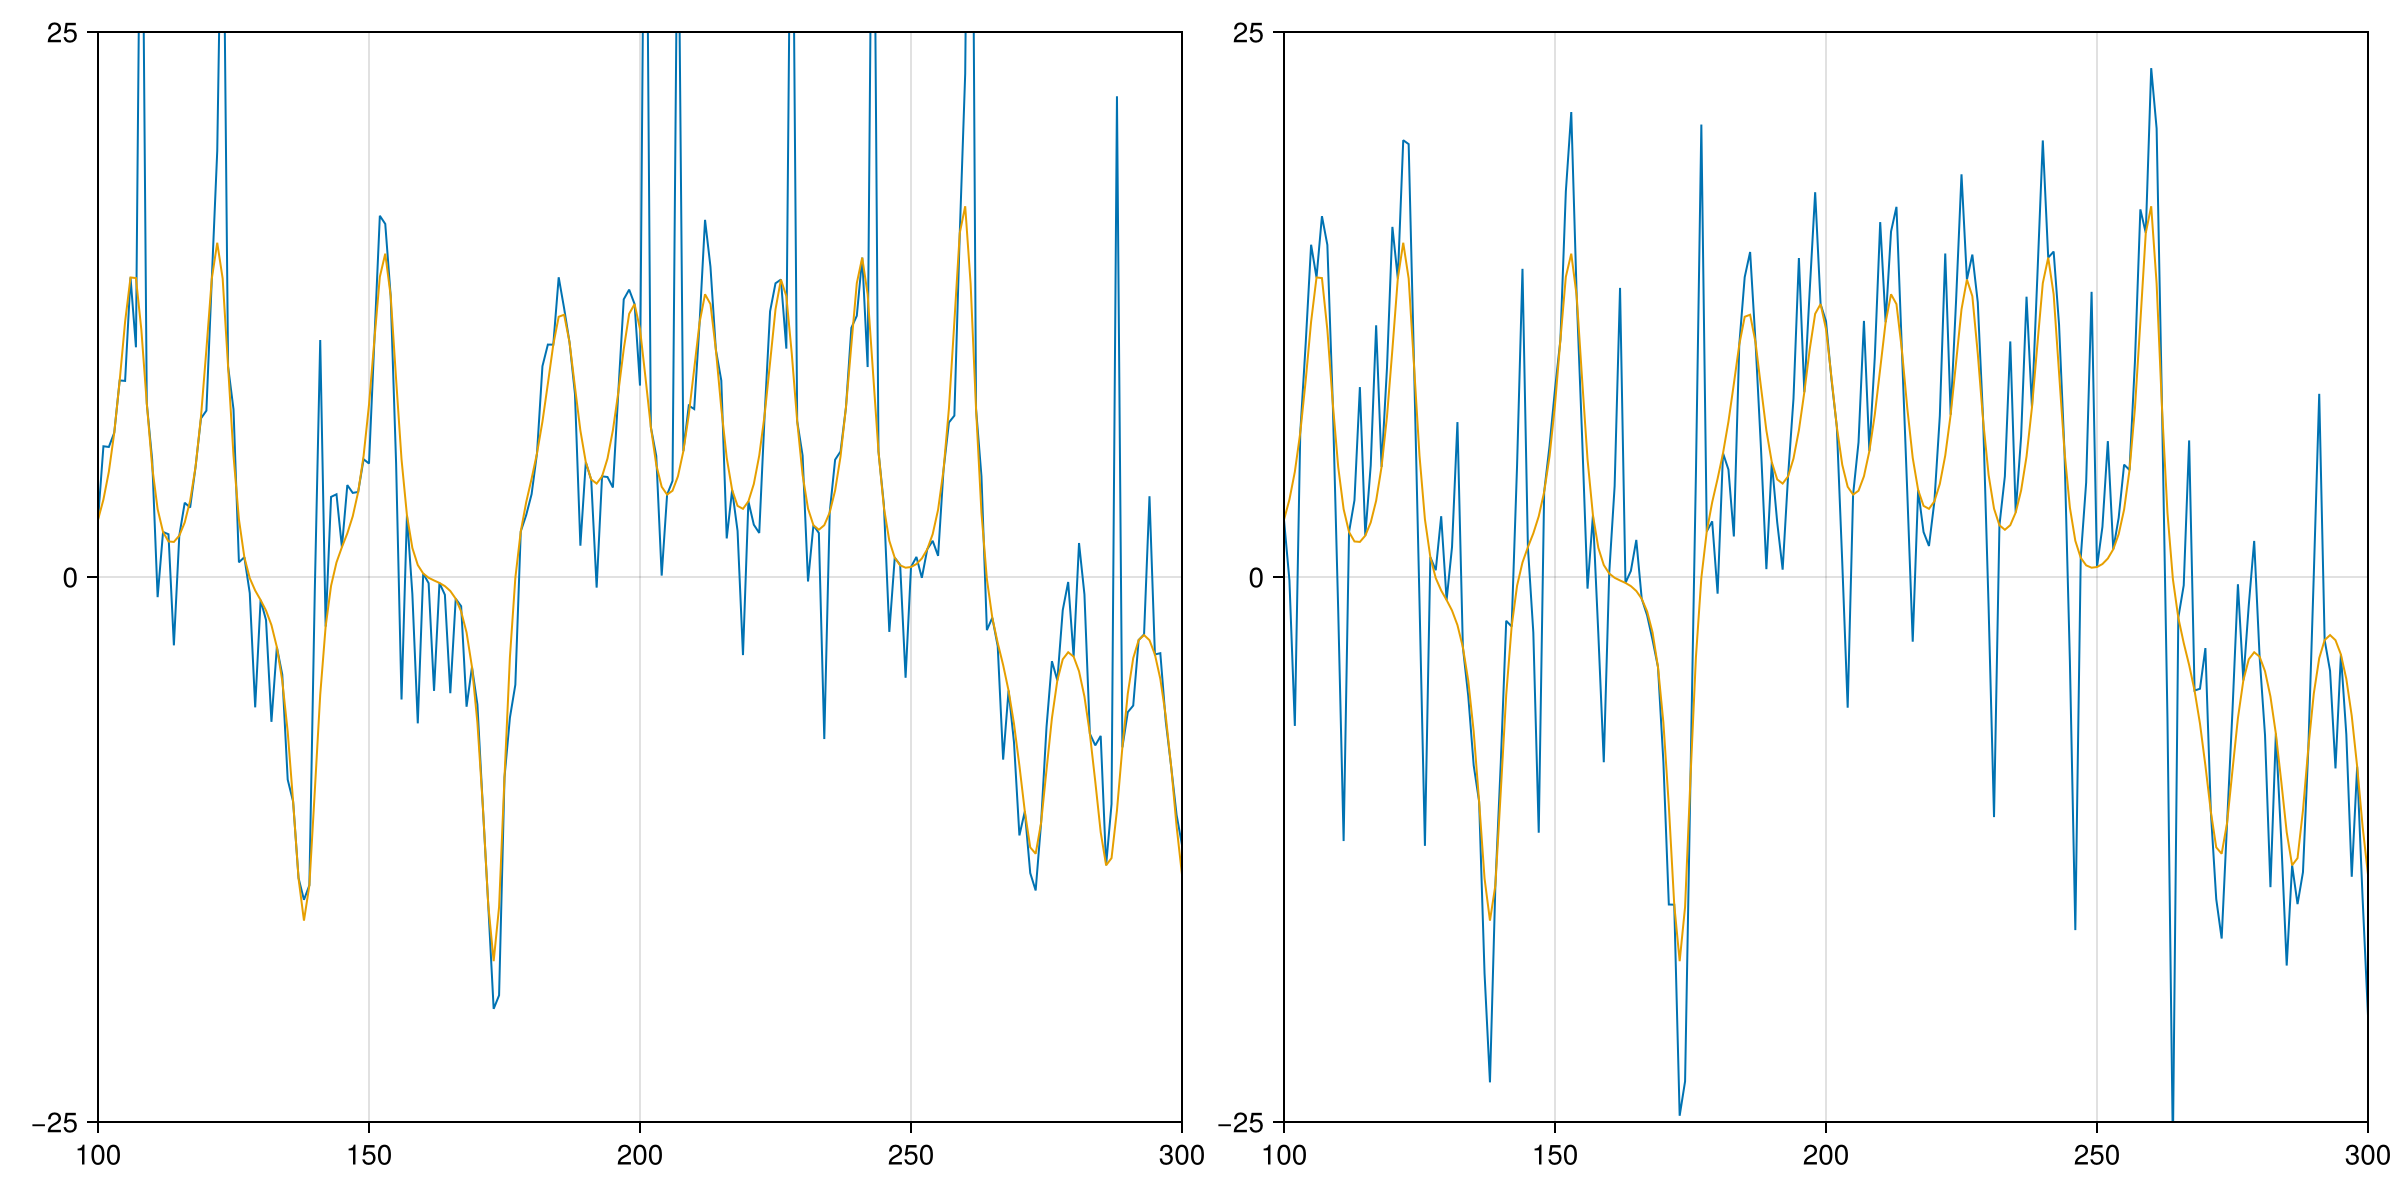

In [28]:
compare_preds(ON_preds_multistep, vanilla_preds_multistep, 100, 300, ignore_first=20, offset=0)

In [29]:
ON_preds_multistep = create_pred_for_params_multi_step(3, 4; k = 400)
vanilla_preds_multistep = create_pred_for_params_multi_step(1, 4; k = 1200);

Ordinal network reservoir prediction RMSE: 21.526147063268912
Vanilla prediction RMSE: 14.484932783313983
Ordinal network reservoir prediction turning partition RMSE: 46.70053178689948
Vanilla prediction turning partition RMSE: 10.712847101815347


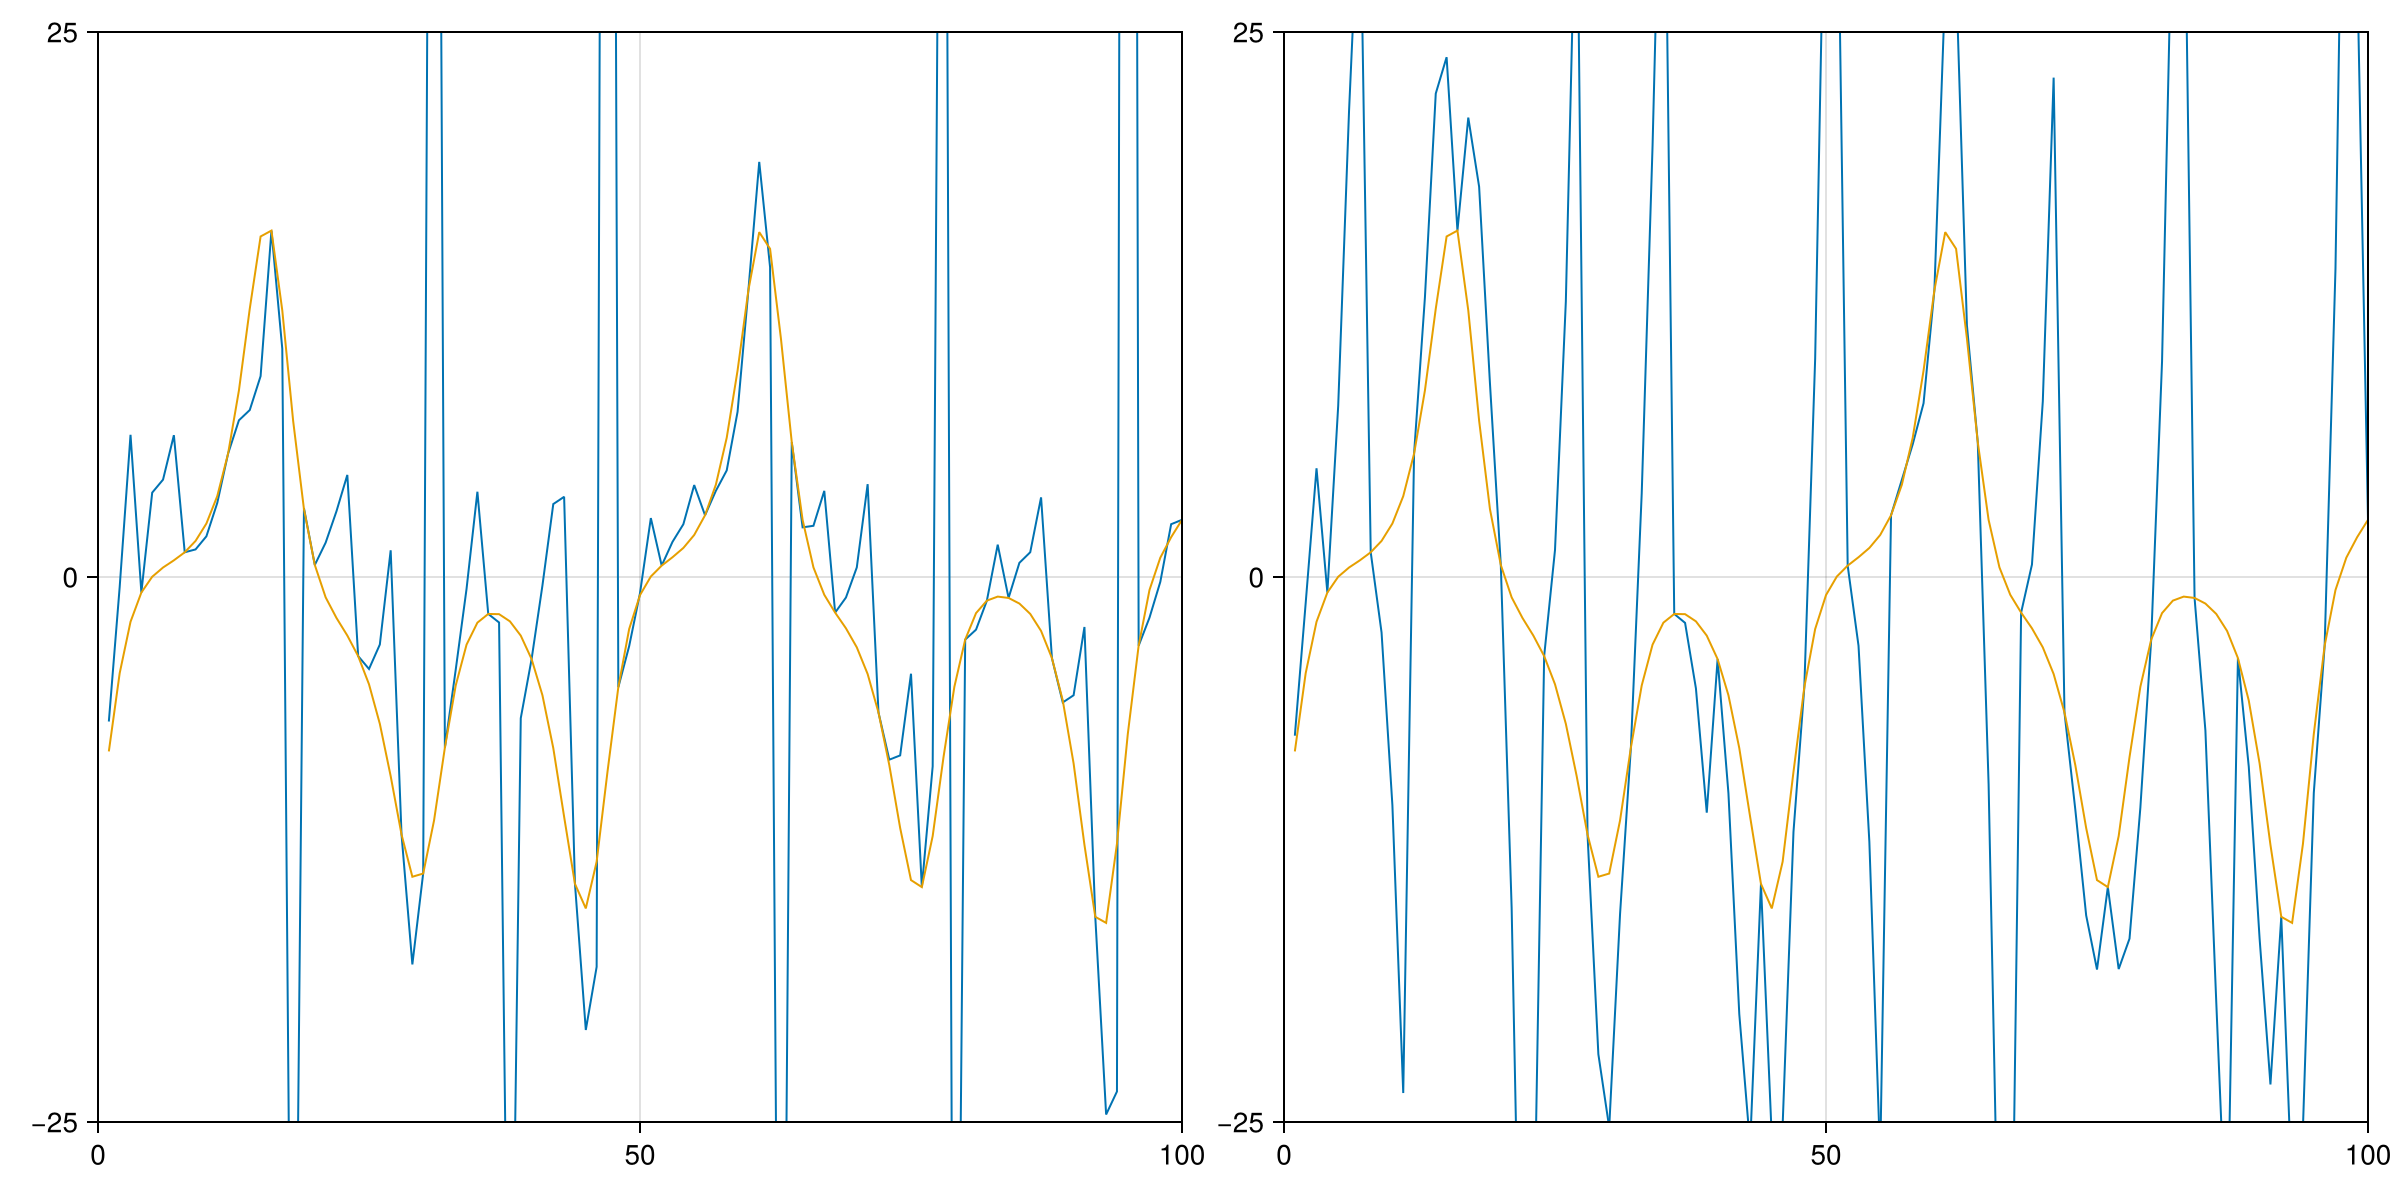

In [30]:
# compare_preds(ON_preds_multistep, vanilla_preds_multistep, 100, 300, ignore_first=20, offset=0)
compare_preds(ON_preds_multistep, vanilla_preds_multistep, 0, 100, ignore_first=20, offset=0)

In [31]:
test_part = create_ordinal_partition(lo_train, 4, 1, 1)
ON_trans_probs = find_probs(test_part)

UndefVarError: UndefVarError: `find_probs` not defined

In [38]:
# if we want it to train better, then we should mask the states before the output rather than mask the readout vector

test_k = 3
test_parts = 3

states = ones(test_k*test_parts, test_k*test_parts)

part = 2

n1 = (part-1)*test_k+1
n2 = part*test_k

states[:,1:n1-1] .= 0
states[:,n2+1:end] .= 0
states[1:n1-1,:] .= 0 
states[n2+1:end,:] .= 0

states

9×9 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [21]:
stts[:,1]

8000-element Vector{Float64}:
  0.0
  0.0
  0.0
 -0.8855873768015823
 -0.8918694465853841
 -0.8945142606516204
 -0.8953824844888286
 -0.8644381421355106
 -0.8693768768236068
 -0.8644645216479642
  ⋮
 -0.8644468447313552
 -0.864444062505199
 -0.8644453447646411
 -0.8644445291123618
 -0.8644439682373585
 -0.8644437595177974
 -0.8724980386251802
 -0.8759914136443797
 -0.8811643796292388

In [43]:
function test_mask_states!(states, partition_symbols, k, num_partitions)
    for part_i in 1:num_partitions
        states[(part_i-1)*k+1:part_i*k, partition_symbols[part_i]] .= 0
    end
end

state = ones(test_k*test_parts, test_k*test_parts)
states = [state, state, state]

# mask_states!(states, [1,2,3], test_k, test_parts)
states[][1:2,1] .= 0

states[1]

MethodError: MethodError: Cannot `convert` an object of type Int64 to an object of type Matrix{Float64}

Closest candidates are:
  convert(::Type{Array{T, N}}, !Matched::StaticArraysCore.SizedArray{S, T, N, N, Array{T, N}}) where {S, T, N}
   @ StaticArrays ~/.julia/packages/StaticArrays/MSJcA/src/SizedArray.jl:88
  convert(::Type{Array{T, N}}, !Matched::StaticArraysCore.SizedArray{S, T, N, M, TData} where {M, TData<:AbstractArray{T, M}}) where {T, S, N}
   @ StaticArrays ~/.julia/packages/StaticArrays/MSJcA/src/SizedArray.jl:82
  convert(::Type{Array{S, N}}, !Matched::PooledArrays.PooledArray{T, R, N}) where {S, T, R, N}
   @ PooledArrays ~/.julia/packages/PooledArrays/Vy2X0/src/PooledArrays.jl:499
  ...


In [ ]:
function train_one_step_pred(x, ESN_params)
    states = run_ESN(x, ESN_params)
    
    target_z = x[2:length(x)]
    predicted_states = states[1:size(states)[1]-1,:]
    
    R = ridge_regression(target_z, predicted_states, ESN_params.β)
    
    return(R, states)
end

function one_step_pred(x, ESN_params, R; S = nothing)
    states = run_ESN(x, ESN_params; S = S)
    preds = states*R
    
    return(preds, states)
end

In [ ]:
function calculate_corr_coeffs(ESN_params, max_τ, x_length)
    u_train = randn(x_length)
    u_test = randn(x_length)
    corr_coeffs = zeros(max_τ+1)
    states_train = run_ESN(u_train, ESN_params)
    states_test = run_ESN(u_test, ESN_params)
    
    train_time = 0
    test_time = 0
    mse = 0

    for delay in 0:1:max_τ
        
        # Train an R for remembering the input 'delay' steps ago
        states_train_later = states_train[1+delay:size(states_train)[1],:]
        u_train_earlier = u_train[1:length(u_train)-delay]
        
        beginning_time = time_ns()

        R = ridge_regression(u_train_earlier, states_train_later, ESN_params.β)
        
        train_time += (time_ns()-beginning_time)/1000000
        
        states_test_later = states_test[1+delay:size(states_test)[1],:]
        u_test_earlier = u_test[1:length(u_test)-delay]
        
        beginning_time = time_ns()
        
        # Make the recollections
        test_preds = states_test_later * R
        
        test_time += (time_ns()-beginning_time)/1000000
        
        mse += mean((u_test_earlier-test_preds).^2)
        
        # Save errors (as correlation)
        corr_coeffs[delay+1] = cor(u_test_earlier, test_preds)#^2
    end
    
    println("Average train time: ", train_time/max_τ)
    println("Average test time: ", test_time/max_τ)
    println("MSE: ", mse/max_τ)
    
    return(corr_coeffs)
end

In [ ]:
function find_max_delay(ESN_params, max_max_τ, x_length; Ɛ=0.03)
    corr_coeffs = calculate_corr_coeffs(ESN_params, max_max_τ, x_length)
    return(findfirst(corr_coeffs .< minimum(corr_coeffs) + Ɛ))
end

In [ ]:
function plot_memory_capacity(ESN_params, max_max_τ, x_length; Ɛ=0.03)
    corr_coeffs = calculate_corr_coeffs(ESN_params, max_max_τ, x_length)
    MCs = cumsum(corr_coeffs)
    
    fig = Figure( size = (800,400), fonts = (; regular = "Tex"), fontsize = 12)
    lines!(Axis(fig[1,1], xlabel=L"\tau", ylabel="Correlation",xlabelsize=20), corr_coeffs)
    ylims!(-0.1,1.1)
    lines!(Axis(fig[1,2], xlabel=L"\tau_{max}", ylabel="Memory Capacity",xlabelsize=20), MCs)
    ylims!(0,maximum(MCs)+1)
    
    println(string(
        "Memory capacity: ",
        findfirst(corr_coeffs .< minimum(corr_coeffs) + Ɛ)
    ))
    
    return(fig)
end

In [ ]:
function one_step_errors(ESN_params)
    R, train_states = train_one_step_pred(lo_train, ESN_params)
    preds, test_states = one_step_pred(lo_test, ESN_params, R)

    return(cor(lo_test[2:end], preds[1:length(preds)-1]))
end

In [ ]:
function plot_one_step_test(ESN_params)
    R, train_states = train_one_step_pred(lo_train, ESN_params)
    preds, test_states = one_step_pred(lo_test, ESN_params, R)
    
    fig = Figure( size = (1200,600))
    ax1 = Axis(fig[1,1])
    lines!(ax1, preds; linewidth = 1.0, color = Cycled(1))
    lines!(ax1, lo_test[2:end]; linewidth = 1.0, color = Cycled(2))
    xlims!(0,200)
    ylims!(-25,25)
    
    ax1 = Axis(fig[2,1])
    lines!(ax1, preds; linewidth = 1.0, color = Cycled(1))
    lines!(ax1, lo_test[2:end]; linewidth = 1.0, color = Cycled(2))
    xlims!(length(lo_test)-200,length(lo_test))
    ylims!(-25,25)
    display(fig)
    
    println(string("Error (correlation): ", cor(preds[1:end-1], lo_test[2:end])))
end

In [ ]:
k = 100
d = k*0.05
ρ = 2.0
α = 1.0
η = 1/maximum(lo_train)
β = 0.001

ESN_params = create_ESN_params(k, d, ρ, α, η, β)

## One-step Prediction, Correlation (error) and Memory Capacity

In [ ]:
plot_one_step_test(ESN_params)
mem_cap_fig = plot_memory_capacity(ESN_params, 30, 10000)

In [ ]:
rho_test_range = 0:0.01:5.0
rho_test_errs = [one_step_errors(create_ESN_params(k, d, ρ_i, α, η, β)) for ρ_i in rho_test_range]

In [73]:
# save("memory_capacity.pdf", mem_cap_fig)

In [ ]:
corr_coeffs = calculate_corr_coeffs(ESN_params, 30, 10000)
MCs = cumsum(corr_coeffs)

fig = Figure( size = (400,400), fonts = (; regular = "Tex"), fontsize = 16)
lines!(Axis(fig[1,1], xlabel=L"\tau", ylabel="Correlation",xlabelsize=20), corr_coeffs)
ylims!(-0.1,1.1)

# save("correlation.pdf", fig)

fig

In [ ]:
fig = Figure( size = (400,400), fonts = (; regular = "Tex"), fontsize = 16)

lines!(Axis(fig[1,1], xlabel=L"\tau_{max}", ylabel="Memory Capacity",xlabelsize=20), MCs)
ylims!(0,maximum(MCs)+1)

# save("memory_capacity.pdf", fig)

fig

## Spectral radius vs error (correlation)

In [ ]:
# plot(collect(rho_test_range),
#     rho_test_errs)
f = Figure()

ax = Axis(f[1, 1], xlabel = "ρ", ylabel = "Error (correlation)",
    title = "Title")
scatter!(collect(rho_test_range), rho_test_errs)

f

When the spectral radius is low, the correlation of the predicted to the actual trajectory appears to be high (approximately 1). As the spectral radius increases, the correlation drops and becomes more distributed randomly between -1 and 1. The correlation begins to drop between ρ=1 and ρ=2 and appears randomly distributed above around ρ=2.5.

## Spectral radius vs memory capacity

In [77]:
# rho_test_mems = [find_max_delay(create_ESN_params(k, d, ρ_i, α, η, β), 30, 10000)
#         for ρ_i in rho_test_range]

In [78]:
# f = Figure(size = (600, 400), fontsize = 12, fonts = (; regular = "Tex", weird = "Blackchancery"))

# ax = Axis(f[1, 1], xlabel = "ρ", ylabel = "Memory Capacity",
#     title = "Memory Capacity vs. ρ", titlefont=:regular)
# scatter!(collect(rho_test_range), rho_test_mems)
# # set_theme!(font="Computer Modern")

# f

In [79]:
# save("memory capacity vs rho.pdf", f)#, pdf_version="1.4")

In [80]:
# ρ = 1.0
# k_test_range = [10,20,40,80,160]#50,100,200]#,500,1000]

# for k_i in k_test_range
#     println(k_i)
# #     
#     K_test_mem = find_max_delay(create_ESN_params(k_i, k_i*0.05, ρ, α, η, β), 30, 100000)
    
#     println(K_test_mem)
# end

As the spectral radius increases, the memory capacity generally increases up to around ρ=1.5 to ρ=2, afterwhich it decreases and plateaus around 1 to 6. After around ρ=1, the memory capacity becomes more variable, increasing from range of approximately 3-4 to a range of approximately 15.